In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from ts_net import TsNet
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
class Args:
    def __init__(self, data_dir, target_obj, train_mean_std_dir, reg_coef, init_lr,
                 batch_size, win_size, corr_coef_pp, n_folds, rand_seed, max_epochs, logdir, verbose):
        self.data_dir = data_dir
        self.target_obj = target_obj
        self.batch_size = batch_size
        self.win_size = win_size
        self.corr_coef_pp = corr_coef_pp
        self.n_folds = n_folds
        self.rand_seed = rand_seed
        self.max_epochs = max_epochs
        self.logdir = logdir
        self.verbose = verbose
        self.train_mean_std_dir = train_mean_std_dir
        self.reg_coef = reg_coef
        self.init_lr = init_lr

In [3]:
targets = ["Dog_" + str(i+1) for i in xrange(5)] + ["Patient_1", "Patient_2"]
print targets

['Dog_1', 'Dog_2', 'Dog_3', 'Dog_4', 'Dog_5', 'Patient_1', 'Patient_2']


In [4]:
logdir = "../log/pp_0"
!ls -ltrh $logdir

total 108K
drwxrwxr-x 3 yujin yujin 4.0K Apr 25 14:26 Patient_1_20170425114314
-rw-rw-r-- 1 yujin yujin  77K Apr 25 14:26 log_Patient_1.txt
drwxrwxr-x 3 yujin yujin 4.0K Apr 25 15:19 Patient_2_20170425142630
-rw-rw-r-- 1 yujin yujin  16K Apr 25 15:20 log_Patient_2.txt


In [5]:
log_folders = [os.path.join(logdir, f) for f in os.listdir(logdir)]
target_id = 6
target_obj = targets[target_id-1]
tar_dir = [f for f in log_folders if os.path.isdir(f) and target_obj in f][0]
print tar_dir
all_files = os.listdir(tar_dir)
hist_files = np.sort([f for f in all_files if "hist_" in f])
model_files = np.sort(os.listdir(os.path.join(tar_dir, "model")))
print "history files:", hist_files
print "model files:", model_files

../log/pp_0/Patient_1_20170425114314
history files: ['hist_fold0.pkl' 'hist_fold1.pkl' 'hist_fold2.pkl']
model files: ['bestmodel_fold0.h5' 'bestmodel_fold1.h5' 'bestmodel_fold2.h5']


In [6]:
data_dir = "../data"
batch_size = 32
win_size = 20000 if target_id >5 else 4000
corr_coef_pp = 0.0
n_folds = 3
rand_seed = 11
max_epochs = 1
logdir = "./log"
verbose = 0
train_mean_std_dir = "../train_mean_std_dir"

args = Args(data_dir = data_dir,
            target_obj = target_obj,
            batch_size = batch_size,
            win_size = win_size,
            corr_coef_pp = corr_coef_pp,
            n_folds = n_folds,
            rand_seed = rand_seed,
            max_epochs = max_epochs,
            logdir = logdir,
            verbose = verbose,
            train_mean_std_dir = train_mean_std_dir,
            reg_coef = 0,
            init_lr = 0
           )

In [7]:
npzfile_path = os.path.join(args.train_mean_std_dir, args.target_obj, "train_mean_std.npz")
npzfile = np.load(npzfile_path)
train_mean = npzfile["train_mean"]
train_std = npzfile["train_std"]
num_ch = train_mean.size

In [8]:
n_folds = len(hist_files)

# Network Architecture

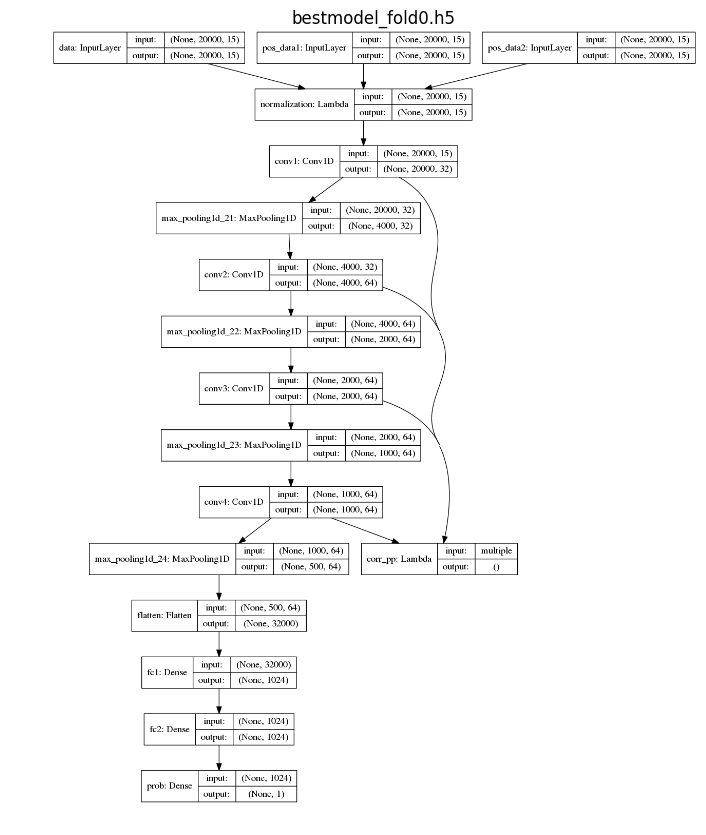

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

modelfile = os.path.join(tar_dir, "model", model_files[0])
model = TsNet(args, train_mean, train_std, num_ch)
model.build_model()
plot_model(model.model, to_file='/tmp/model.png', show_shapes=True)
model_arch = plt.imread("/tmp/model.png")
ax.imshow(model_arch)
ax.set_title(os.path.basename(modelfile))
ax.set_axis_off()

# Learning Curves

In [14]:
model.model.metrics_names

['loss',
 'corr_pp_loss',
 'corr_pp_loss',
 'corr_pp_loss',
 'corr_pp_loss',
 'prob_loss']

../log/pp_0/Patient_1_20170425114314/hist_fold0.pkl
['corr_pp_loss_1' 'corr_pp_loss_2' 'corr_pp_loss_3' 'corr_pp_loss_4' 'loss'
 'prob_loss']
../log/pp_0/Patient_1_20170425114314/hist_fold1.pkl
['corr_pp_loss_1' 'corr_pp_loss_2' 'corr_pp_loss_3' 'corr_pp_loss_4' 'loss'
 'prob_loss']
../log/pp_0/Patient_1_20170425114314/hist_fold2.pkl
['corr_pp_loss_1' 'corr_pp_loss_2' 'corr_pp_loss_3' 'corr_pp_loss_4' 'loss'
 'prob_loss']


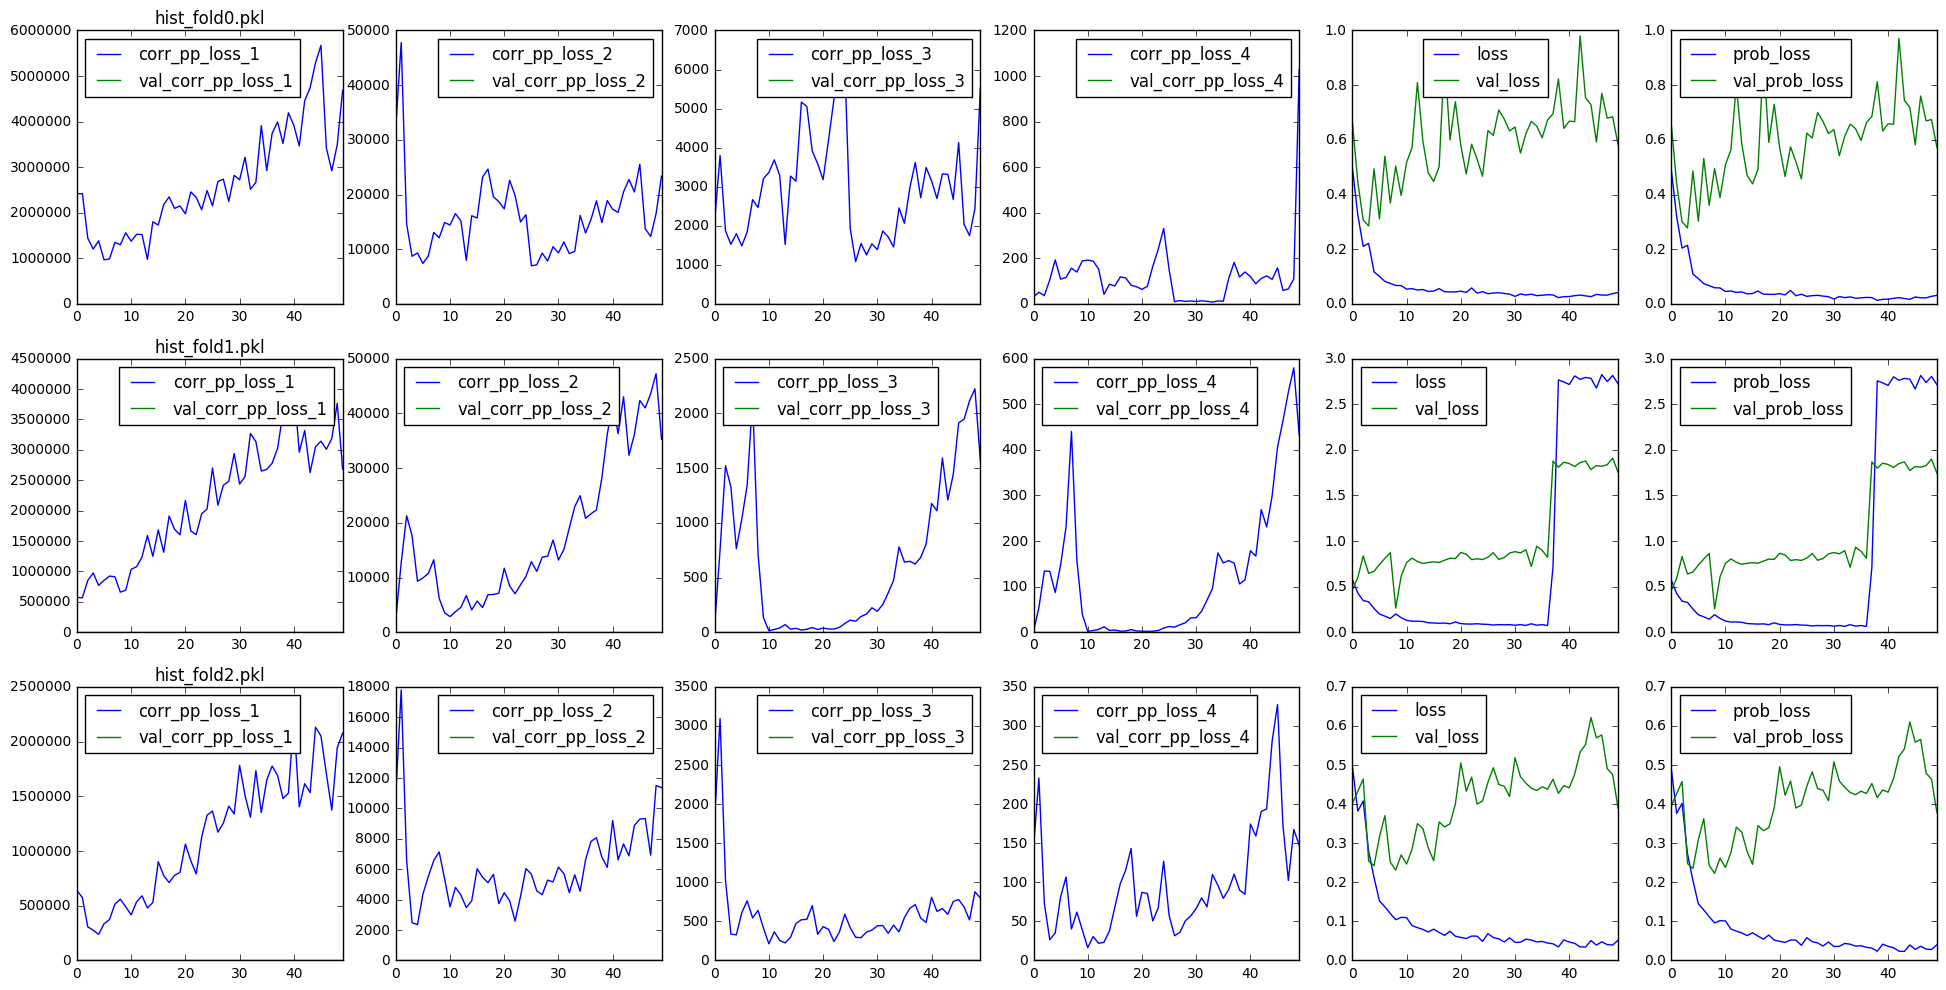

In [20]:
nrows = n_folds
ncols = len(model.model.metrics_names)

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
for row_id in xrange(n_folds):
    hfile = os.path.join(tar_dir, hist_files[row_id])
    print hfile
    with open(hfile, "rb") as f:
        hh = pickle.load(f)
    all_metrics = np.sort([mm for mm in hh.keys() if mm[:4]!="val_"])
    print all_metrics
    for col_id, metric in enumerate(all_metrics):
        ax = axes[row_id, col_id]
        pd.DataFrame({metric: hh[metric], "val_{}".format(metric): hh["val_{}".format(metric)]}).plot(ax=ax)
        if col_id == 0:
            ax.set_title(os.path.basename(hfile))